## 一、生成搜索网格 Anchor Boxes
SSD网络的一个关键点是生成搜索网格（anchor boxes），SSD会在卷积网络的4、7、8、9、10、11这六层的特征图中生成锚框，数据如下：  

层数 | 卷积后特征的大小 | 锚框增强比例 |anchor size:(min_size, max_size)| 单个网格增强得到的锚框数目 | 总锚框数
- |::| : : | : : | : : | : :
4 | [38, 38] | [2, 0.5] |(21., 45.)  | 4 | 4 x 38 x 38
7 | [19, 19] | [2, 0.5, 3, 1/3] | (45., 99.) | 6 | 6 x 19 x 19
8|	[10,10]|	[2,0.5,3,1/3]| (99., 153.) |	6	|6 x 10 x 10
9	|[5,5]	|[2,0.5,3,1/3]| (153., 207.) |	6	|6 x 5 x 5
10	|[3,3]|	[2,0.5]| (207., 261.) |	4|	4 x 3 x 3
11|	[1,1]	|[2,0.5]| (261., 315.) |	4	|4 x 1 x 1

**每一层特征图的锚框生成机制如下所示：**  
1. 生成全部网格中心点坐标(offset=0.5)，乘以step之后就可以得到该特征图中的锚框中点在原图中的映射坐标，最后还需要做一个归一化处理（除以原图的size）。  

2. 对特征图中的每一个点生成一组（4个或6个）锚框的长宽  
首先是两个默认锚框：a、边长为$min\_size$，b、边长为$\sqrt{min\_size\times max\_size}$  
其次是按照设定长宽比确定的锚框：$$width: min\_size \times \sqrt{ratio}\\
height: \frac {min\_size}{\sqrt{ratio}} $$
上述得到的锚框也都需要除以图片的size进行归一化

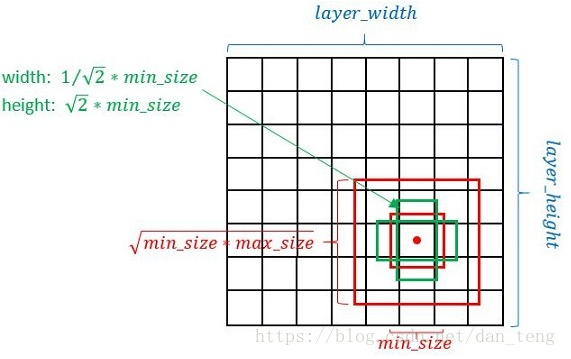

### 锚框生成程序

In [1]:
# 网络参数如下所示
import math
import numpy as np
anchor_steps=[8, 16, 32, 64, 100, 300]         # 特征图与原图的比例
feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]      # 特征图尺寸
anchor_nums = [4, 6, 6, 6, 4, 4]      # 特征图中每个像素点的锚框数
anchor_sizes=[(21., 45.),
              (45., 99.),
              (99., 153.),
              (153., 207.),
              (207., 261.),
              (261., 315.)]
anchor_ratios=[[2, .5],
               [2, .5, 3, 1./3],
               [2, .5, 3, 1./3],
               [2, .5, 3, 1./3],
               [2, .5],
               [2, .5]]

In [2]:
# 单层网络的锚框生成函数
def ssd_anchor_one_layer(img_shape, feat_shape, sizes, ratios, 
                         step, offset=0.5, dtype=np.float32):
    """
    计算SSD网络中单个特征图的默认锚框
    Args:
        img_shape: 图片的尺寸
        feat_shape: 特征图的尺寸
        size: 锚框的尺寸
        ratio: 该特征图使用的锚框比例
        step: 该特征图与原图的比例关系
        offset: 锚框中心相对于网格左上角点的偏移量
    """
    y, x = np.mgrid[0: feat_shape[0], 0: feat_shape[1]]   # 生成网格左上角点
    y = (y.astype(dtype) + offset) * step / img_shape[0]  # 得到锚框在原图上的中点坐标
    x = (x.astype(dtype) + offset) * step / img_shape[1] 
    
    # expand dims to support easy broadcasting
    y = np.expand_dims(y, axis=-1)
    x = np.expand_dims(x, axis=-1)
    
    # compute relative height and width
    # tries to follow the origninal implementation of SSD for the order
    num_anchors = len(sizes) + len(ratios)
    h = np.zeros((num_anchors,), dtype=dtype)
    w = np.zeros((num_anchors,), dtype=dtype)
    
    # add first anchor boxes's width and height with ratio=1.
    h[0] = sizes[0] / img_shape[0]
    w[0] = sizes[0] / img_shape[1]
    
    # add second anchor boxes's width and height
    h[1] = math.sqrt(sizes[0] * sizes[1]) / img_shape[0]
    w[1] = math.sqrt(sizes[0] * sizes[1]) / img_shape[1]
    
    for i, ratio in enumerate(ratios):
        h[i + 2] = sizes[0] / img_shape[0] / (ratio**0.5)
        w[i + 2] = sizes[0] / img_shape[1] * (ratio**0.5)
        
    return x, y, w, h

## 二、SSD网络输出解码
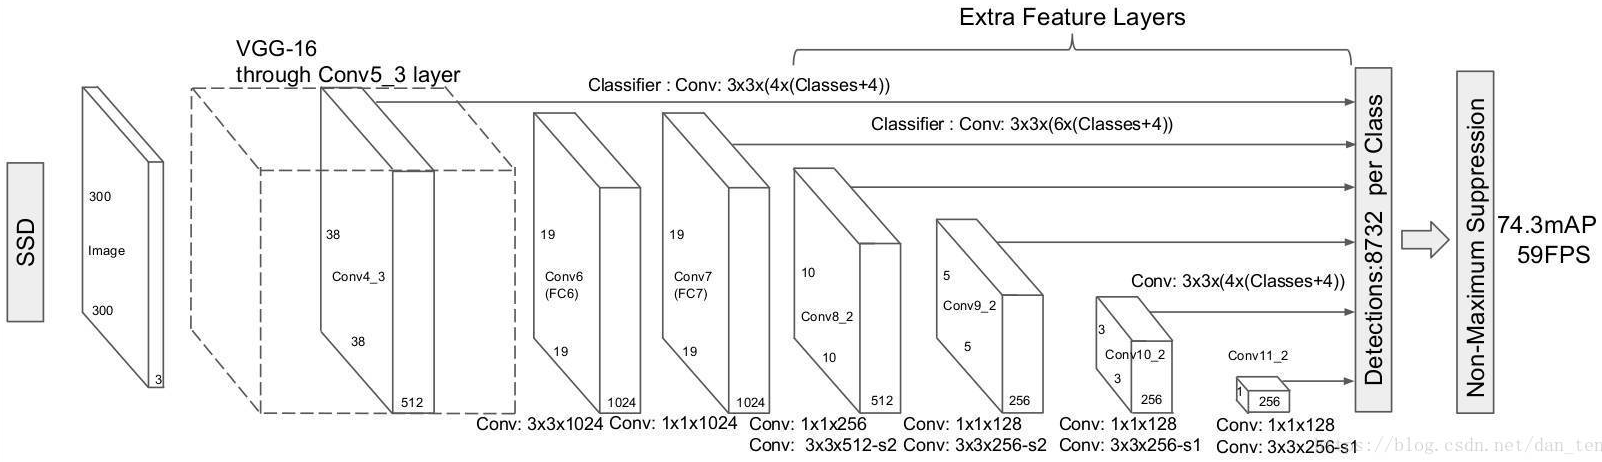

如上图所示，在SSD网络中，通过从卷积网络的6层卷积层中抽取特征图，并且对每个特征图中的每个像素点构建候选框，总共可以产生8732个预测框的输出数据，每个输出数据中不是直接包含着预测框的左上角和右下角坐标值，而是偏移量，所以需要通过与预选框进行计算才能得到最终的检测框的坐标。

假设检验框用b表示，存储的内容为（$b_{xmin}, b_{ymin}, b_{xmax}, b_{ymax}$）,预选框用p表示，存储的内容为（$p_{xmin}, p_{ymin}, p_{xmax}, p_{ymax}$）,偏移量用t表示，存储的内容为（$t_x, t_y, t_{height}, t_{width}$）,其中t就是网络的输出，p为生成的锚框，b就是最终需要解码得到的检测框。

SSD 网络中编码的方式与 R-CNN 系列网络的编码方式一致：  
\begin{equation}
t_x = (b_x - p_x) / p_{width}\\
t_y = (b_y - p_y) / p_{height}\\
t_{width} = log(\frac {b_{width}}{p_{width}})\\
t_{height} = log(\frac {b_{height}}{p_{height}})
\end{equation}

在 SSD 网络中偏移量还需要乘以 prior_scaling 项：（$scale_x, scale_y, scale_w, scale_h$）
\begin{equation}
scale_x \times t_x = (b_x - p_x) / p_{width}\\
scale_y \times t_y = (b_y - p_y) / p_{height}\\
scale_w \times t_{width} = log(\frac {b_{width}}{p_{width}})\\
scale_h \times t_{height} = log(\frac {b_{height}}{p_{height}})
\end{equation}

In [3]:
# 网络解码
def ssd_decode(location, box, prior_scaling):
		"""
		对单层特征图的网络输出解码
		Args:
			location: 5-D tensor, 网络输出的预测坐标值, [batch_size, height, width, anchor_box, coordinations]
			box: 默认的锚框坐标及长宽，(x, y, w, h)
			prior_scaling: 先验框的缩放比例
		Returns:
			bboxes: 5-D tensor, 解码后的预测框， [batch_size, height, width, box, coordination]
					其中coordination表示的是预测框的左上角坐标和右下角坐标
		"""

		anchor_x, anchor_y, anchor_w, anchor_h = box 
		center_x = location[:, :, :, :, 0] * prior_scaling[0] * anchor_w + anchor_x 
		center_y = location[:, :, :, :, 1] * prior_scaling[1] * anchor_h + anchor_y
		w = anchor_w * tf.exp(location[:, :, :, :, 2] * prior_scaling[2])
		h = anchor_h * tf.exp(location[:, :, :, :, 3] * prior_scaling[3])
		bboxes = tf.stack([center_x - w / 2.0, center_y - h / 2.0, 
						   center_x + w / 2.0, center_y + h / 2.0],
						   axis=-1)
		return bboxes

## 三、SSD网络的损失函数
SSD网络的损失函数包含用于分类的 log loss 和用于检测框坐标回归的 smooth L1，并对正负样本比例进行了控制，可以提高优化速度和训练结果的稳定性。
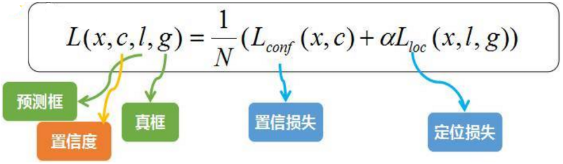

### 1、loc的损失函数：smooth L1
$$
smooth_{L1}(x) = 
\begin{cases}
\begin{aligned}
0.5x^2 \qquad &if |x|<1\\
|x|-0.5 \quad&otherwise
\end{aligned}
\end{cases}
$$

In [4]:
def smooth_L1_loss(self, y_true, y_pred):
    """
    通过 smooth L1 计算坐标偏差的损失函数
    Args:
        y_ture: 3-D tensor, 真实目标框的坐标，shape=[batch_size, n_boxes, 4], 
                最后一个维度的信息分别为（xmin, ymin, xmax, ymax）
        y_pred: 3-D tensor, 预测的目标框坐标，shape 应该和 y_true 保持一致
    """
    absolute_loss = tf.abs(y_true - y_pred)
    square_loss = 0.5 * tf.square(absolute_loss)
    l1_loss = tf.where(tf.less(absolute_loss, 1.), square_loss, absolute_loss - .5)
    return tf.reduce_sum(l1_loss, axis=-1)

### 2、conf的损失函数：Log loss


In [5]:
def log_loss(self, y_true, y_pred):
    """
    计算SSD网络中每个检测框类别预测的损失函数
    Args：
        y_ture: 3-D tensor, 真实目标框的坐标，shape=[batch_size, n_boxes, 4], 
                最后一个维度的信息分别为（xmin, ymin, xmax, ymax）
        y_pred: 3-D tensor, 预测的目标框坐标，shape 应该和 y_true 保持一致
    """
    # 确保y_pred中不包含0，否则会使log函数崩溃
    y_pred = tf.maximum(y_pred, 1e-15)
    log_loss = -tf.reduce_sum(y_ture * tf.log(y_pred), axis=-1)
    return log_loss